In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import seaborn as sns
import pickle

%matplotlib inline

#### Bringing in my pickle file

In [2]:
with open('../data/full_race_data.pickle', 'rb') as file:
    full = pickle.load(file)

In [3]:
full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5162881 entries, 0 to 5162880
Data columns (total 29 columns):
 #   Column           Dtype         
---  ------           -----         
 0   track_id         object        
 1   race_date        datetime64[ns]
 2   race_number      int64         
 3   program_number   object        
 4   horse_id         int64         
 5   weight_carried   float64       
 6   jockey           object        
 7   odds             float64       
 8   finishing_place  int64         
 9   horse_name       object        
 10  course_type      object        
 11  track_condition  object        
 12  race_type        object        
 13  purse            int64         
 14  post_time        int64         
 15  latitude         float64       
 16  longitude        float64       
 17  n_lat            float64       
 18  n_lon            float64       
 19  distance_id      int64         
 20  run_up_distance  int64         
 21  trakus_index     int64         

In [4]:
#setting display so that values are not in scientific notation
pd.set_option('display.float_format', lambda x: '%.9f' % x)

#### Pulling stats for the calculated value columns to allow us to identify mathematical outliers

In [7]:
stats = full[['seg_dist_ft', 'seg_speed_ft/s', 'seg_mph', 'cum_dist_ft', 'avg_speed_ft/s', 'avg_mph',
       'seg_accel_ft/s2']].describe()

In [8]:
stats

,seg_dist_ft,seg_speed_ft/s,seg_mph,cum_dist_ft,avg_speed_ft/s,avg_mph,seg_accel_ft/s2
count,5148039.000000000,5148039.000000000,5148039.000000000,5148039.000000000,5148039.000000000,5148039.000000000,5133197.000000000
mean,15.163486294,60.653945175,41.354962618,2773.016270459,59.313691954,40.441153604,0.337416375
std,2.341767144,9.367068575,6.386637664,1707.289747535,8.503478878,5.797826508,20.482940313
min,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,-8421.974352287
25%,14.472954048,57.891816193,39.471692858,1340.671166952,59.150244377,40.329712074,-3.735356735
50%,15.626947901,62.507791605,42.618948820,2740.403660227,61.600391784,42.000267124,0.000220540
75%,16.460889424,65.843557695,44.893334791,4064.088948216,63.409168530,43.233523996,3.990281087
max,798.521549964,3194.086199854,2177.786045297,11224.018429606,316.884340201,216.057504677,12638.710927077


#### First calculating outliers using Q3 + 1.5 IQR method

In [10]:
seg_dist_IQR = (stats['seg_dist_ft'][6] - stats['seg_dist_ft'][4])
high_outliers = full.loc[full['seg_dist_ft'] > (stats['seg_dist_ft'][6] + 1.5*seg_dist_IQR)]
len(high_outliers) / len(full) * 100

0.062465123639301394

0.0625% of all rows contain high outliers when calculated using Q3 + 1.5 * IQR

In [11]:
high_stats = high_outliers[['seg_dist_ft', 'seg_speed_ft/s', 'seg_mph', 'cum_dist_ft', 'avg_speed_ft/s', 'avg_mph',
       'seg_accel_ft/s2']].describe()

In [12]:
high_stats

,seg_dist_ft,seg_speed_ft/s,seg_mph,cum_dist_ft,avg_speed_ft/s,avg_mph,seg_accel_ft/s2
count,3225.000000000,3225.000000000,3225.000000000,3225.000000000,3225.000000000,3225.000000000,3202.000000000
mean,27.704241943,110.816967771,75.557023478,1842.369115946,58.239539240,39.708776753,165.393679247
std,31.192020612,124.768082448,85.069147121,1794.311220828,16.551164146,11.284884645,582.402695240
min,19.442839972,77.771359886,53.025927194,19.457150434,5.134662332,3.500906135,-5217.547271284
25%,19.774435345,79.097741378,53.930278211,486.383302332,55.601269567,37.909956522,11.165972572
50%,20.470993373,81.883973494,55.829981926,1017.198760390,60.855613716,41.492463896,34.290183003
75%,22.778792552,91.115170207,62.123979685,2853.610484391,64.225763173,43.790293071,84.225100242
max,798.521549964,3194.086199854,2177.786045297,8342.796344430,316.884340201,216.057504677,12638.710927077


Given the fact that the current world record for a thoroughbred race horse in terms of speed is running 2 furlongs/0.25 miles at just under 44 mph, just over 53 mph seems very reasonable to call an outlier (and likely an errant) reading for any given segment

In [13]:
high_outliers.sort_values('trakus_index')

,track_id,race_date,race_number,program_number,horse_id,weight_carried,jockey,odds,finishing_place,horse_name,...,distance_id,run_up_distance,trakus_index,seg_dist_ft,seg_speed_ft/s,seg_mph,cum_dist_ft,avg_speed_ft/s,avg_mph,seg_accel_ft/s2
3611372,BEL,2019-09-27,4,8,3815,119.000000000,Junior Alvarado,350.000000000,7,Adriatic Holiday,...,800,172,1,23.130662701,92.522650802,63.083625545,23.130662701,92.522650802,63.083625545,NaN
4334556,SAR,2019-07-26,1,2,1423,124.000000000,Tyler Gaffalione,800.000000000,4,Handle With Care,...,700,32,1,24.867210228,99.468840914,67.819664258,24.867210228,99.468840914,67.819664258,NaN
3539972,BEL,2019-09-22,2,2,2355,121.000000000,Joel Rosario,160.000000000,2,Shannon's Girl,...,600,126,1,26.686746221,106.746984884,72.782035146,26.686746221,106.746984884,72.782035146,NaN
3526066,BEL,2019-09-21,8,2,3253,122.000000000,Javier Castellano,330.000000000,2,Stella di Camelot (IRE),...,800,142,1,33.193140195,132.772560780,90.526745984,33.193140195,132.772560780,90.526745984,NaN
4082016,BEL,2019-10-26,9,9,3996,120.000000000,Irad Ortiz Jr.,335.000000000,1,Buy Land and See,...,800,144,1,21.751052255,87.004209021,59.321051604,21.751052255,87.004209021,59.321051604,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4565536,SAR,2019-08-04,5,2,1719,118.000000000,Javier Castellano,320.000000000,1,Fools Gold,...,1200,65,495,19.628131614,78.512526457,53.531268037,7646.256709481,61.787933006,42.128136139,17.953847088
4565537,SAR,2019-08-04,5,2,1719,118.000000000,Javier Castellano,320.000000000,1,Fools Gold,...,1200,65,496,20.356686786,81.426747144,55.518236688,7666.613396267,61.827527389,42.155132310,11.656882748
1281216,AQU,2019-11-03,8,11,1725,124.000000000,Junior Alvarado,1010.000000000,12,Pamina,...,1200,123,513,20.147876228,80.591504912,54.948753348,7482.148732095,58.340340991,39.777505220,58.078674597
2821611,BEL,2019-06-08,13,4,3344,116.000000000,Irad Ortiz Jr.,470.000000000,8,War Story,...,1200,78,564,20.053293226,80.213172903,54.690799705,8276.138984240,58.696021165,40.020014429,253.884309347


In [14]:
#Examining full race readings for some of the horses that appear in the high_outliers dataframe

full.loc[(full['horse_id'] == 4039) & (full['race_date'] == '2019-09-02')].iloc[:10]
#I suspect this is fairly representative of other occassions where there are several "blank" readings preceding a single
#high outlier reading

,track_id,race_date,race_number,program_number,horse_id,weight_carried,jockey,odds,finishing_place,horse_name,...,distance_id,run_up_distance,trakus_index,seg_dist_ft,seg_speed_ft/s,seg_mph,cum_dist_ft,avg_speed_ft/s,avg_mph,seg_accel_ft/s2
5158617,SAR,2019-09-02,10,5,4039,122.000000000,Irad Ortiz Jr.,520.000000000,5,By Your Side,...,700,32,1,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,NaN
5158618,SAR,2019-09-02,10,5,4039,122.000000000,Irad Ortiz Jr.,520.000000000,5,By Your Side,...,700,32,2,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000
5158619,SAR,2019-09-02,10,5,4039,122.000000000,Irad Ortiz Jr.,520.000000000,5,By Your Side,...,700,32,3,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000
5158620,SAR,2019-09-02,10,5,4039,122.000000000,Irad Ortiz Jr.,520.000000000,5,By Your Side,...,700,32,4,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000
5158621,SAR,2019-09-02,10,5,4039,122.000000000,Irad Ortiz Jr.,520.000000000,5,By Your Side,...,700,32,5,28.965550971,115.862203885,78.996957192,28.965550971,23.172440777,15.799391438,463.448815541
5158622,SAR,2019-09-02,10,5,4039,122.000000000,Irad Ortiz Jr.,520.000000000,5,By Your Side,...,700,32,6,7.391300778,29.565203112,20.158093030,36.356851749,24.237901166,16.525841704,-345.188003093
5158623,SAR,2019-09-02,10,5,4039,122.000000000,Irad Ortiz Jr.,520.000000000,5,By Your Side,...,700,32,7,8.080710804,32.322843217,22.038302193,44.437562553,25.392892888,17.313336059,11.030560420
5158624,SAR,2019-09-02,10,5,4039,122.000000000,Irad Ortiz Jr.,520.000000000,5,By Your Side,...,700,32,8,10.575578298,42.302313192,28.842486267,55.013140852,27.506570426,18.754479835,39.917879902
5158625,SAR,2019-09-02,10,5,4039,122.000000000,Irad Ortiz Jr.,520.000000000,5,By Your Side,...,700,32,9,10.645107643,42.580430574,29.032111754,65.658248495,29.181443776,19.896438937,1.112469525
5158626,SAR,2019-09-02,10,5,4039,122.000000000,Irad Ortiz Jr.,520.000000000,5,By Your Side,...,700,32,10,11.190189080,44.760756320,30.518697490,76.848437575,30.739375030,20.958664793,8.721302987


In [15]:
full.loc[(full['horse_id'] == 10) & (full['race_date'] == '2019-01-01')].iloc[45:65]
#It's harder to figure out what might be going on here other than perhaps the readings were not happening at even intervals

,track_id,race_date,race_number,program_number,horse_id,weight_carried,jockey,odds,finishing_place,horse_name,...,distance_id,run_up_distance,trakus_index,seg_dist_ft,seg_speed_ft/s,seg_mph,cum_dist_ft,avg_speed_ft/s,avg_mph,seg_accel_ft/s2
3425,AQU,2019-01-01,2,7,10,121.000000000,Eric Cancel,3975.000000000,6,Kavansberg,...,600,48,46,17.961555917,71.846223670,48.986061592,662.203647858,57.582925901,39.261085840,3.870511490
3426,AQU,2019-01-01,2,7,10,121.000000000,Eric Cancel,3975.000000000,6,Kavansberg,...,600,48,47,20.369946565,81.479786259,55.554399721,682.573594423,58.091369738,39.607752093,38.534250357
3427,AQU,2019-01-01,2,7,10,121.000000000,Eric Cancel,3975.000000000,6,Kavansberg,...,600,48,48,21.379538551,85.518154205,58.307832411,703.953132974,58.662761081,39.997337100,16.153471784
3428,AQU,2019-01-01,2,7,10,121.000000000,Eric Cancel,3975.000000000,6,Kavansberg,...,600,48,49,19.370861691,77.483446765,52.829622793,723.323994665,59.046856707,40.259220481,-32.138829759
3429,AQU,2019-01-01,2,7,10,121.000000000,Eric Cancel,3975.000000000,6,Kavansberg,...,600,48,50,14.136533750,56.546135001,38.554182954,737.460528416,58.996842273,40.225119731,-83.749247057
3430,AQU,2019-01-01,2,7,10,121.000000000,Eric Cancel,3975.000000000,6,Kavansberg,...,600,48,51,13.624152172,54.496608689,37.156778651,751.084680588,58.908602399,40.164956180,-8.198105248
3431,AQU,2019-01-01,2,7,10,121.000000000,Eric Cancel,3975.000000000,6,Kavansberg,...,600,48,52,18.965568636,75.862274543,51.724278096,770.050249224,59.234634556,40.387250832,85.462663416
3432,AQU,2019-01-01,2,7,10,121.000000000,Eric Cancel,3975.000000000,6,Kavansberg,...,600,48,53,21.688627545,86.754510182,59.150802395,791.738876769,59.753877492,40.741280107,43.568942554
3433,AQU,2019-01-01,2,7,10,121.000000000,Eric Cancel,3975.000000000,6,Kavansberg,...,600,48,54,17.506250808,70.025003232,47.744320384,809.245127577,59.944083524,40.870966038,-66.918027798
3434,AQU,2019-01-01,2,7,10,121.000000000,Eric Cancel,3975.000000000,6,Kavansberg,...,600,48,55,18.238478188,72.953912750,49.741304146,827.483605765,60.180625874,41.032244913,11.715638072


In [16]:
full.loc[(full['horse_id'] == 3344) & (full['race_date'] == '2019-06-08')].iloc[560:]
#This is another very strange pattern of readings

,track_id,race_date,race_number,program_number,horse_id,weight_carried,jockey,odds,finishing_place,horse_name,...,distance_id,run_up_distance,trakus_index,seg_dist_ft,seg_speed_ft/s,seg_mph,cum_dist_ft,avg_speed_ft/s,avg_mph,seg_accel_ft/s2
2821608,BEL,2019-06-08,13,4,3344,116.000000000,Irad Ortiz Jr.,470.000000000,8,War Story,...,1200,78,561,9.288783352,37.155133410,25.333045506,8234.719774262,58.714579496,40.032667837,100.936856660
2821609,BEL,2019-06-08,13,4,3344,116.000000000,Irad Ortiz Jr.,470.000000000,8,War Story,...,1200,78,562,17.180392861,68.721571442,46.855616891,8251.900167122,58.732385531,40.044808316,126.265752128
2821610,BEL,2019-06-08,13,4,3344,116.000000000,Irad Ortiz Jr.,470.000000000,8,War Story,...,1200,78,563,4.185523892,16.742095567,11.415065159,8256.085691014,58.657802423,39.993956196,-207.917903501
2821611,BEL,2019-06-08,13,4,3344,116.000000000,Irad Ortiz Jr.,470.000000000,8,War Story,...,1200,78,564,20.053293226,80.213172903,54.690799705,8276.138984240,58.696021165,40.020014429,253.884309347
2821612,BEL,2019-06-08,13,4,3344,116.000000000,Irad Ortiz Jr.,470.000000000,8,War Story,...,1200,78,565,14.898674317,59.594697267,40.632748135,8291.037658556,58.697611742,40.021098914,-82.473902546
2821613,BEL,2019-06-08,13,4,3344,116.000000000,Irad Ortiz Jr.,470.000000000,8,War Story,...,1200,78,566,51.758685874,207.034743496,141.160052380,8342.796344430,58.959691480,40.199789644,589.760184916
2821614,BEL,2019-06-08,13,4,3344,116.000000000,Irad Ortiz Jr.,470.000000000,8,War Story,...,1200,78,567,19.187930233,76.751720932,52.330718816,8361.984274663,58.991070721,40.221184581,-521.132090257
2821615,BEL,2019-06-08,13,4,3344,116.000000000,Irad Ortiz Jr.,470.000000000,8,War Story,...,1200,78,568,8.478563037,33.914252148,23.123353737,8370.462837700,58.946921392,40.191082766,-171.349875133
2821616,BEL,2019-06-08,13,4,3344,116.000000000,Irad Ortiz Jr.,470.000000000,8,War Story,...,1200,78,569,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
#Function to get a count of races at each track on each date races were held
def grouped_race_count(df):
    grouped_counts = (
        df
        .groupby(['track_id', 'race_date'])
        ['race_number']
        .nunique()
        .to_frame()
        .reset_index()
        .rename(columns = {'race_number' : 'number_of_races'})
    )
    
    return grouped_counts

#Function to sum all races by track across all dates
def track_sums(df):
    track_totals = df.groupby('track_id')['number_of_races'].sum()
    return track_totals

In [18]:
#total race count by track
race_count = grouped_race_count(full)
sum_all_races = track_sums(race_count)
sum_all_races

track_id
AQU    825
BEL    770
SAR    396
Name: number_of_races, dtype: int64

In [19]:
high_outlier_races = grouped_race_count(high_outliers)

sum_high_outlier_races = track_sums(high_outlier_races)

In [20]:
#taking a look at which tracks/dates had the most races with high outlier readings
high_outlier_races.sort_values('number_of_races', ascending=False).head(30)

,track_id,race_date,number_of_races
178,SAR,2019-08-04,11
177,SAR,2019-08-03,11
168,SAR,2019-07-21,11
163,SAR,2019-07-13,10
187,SAR,2019-08-17,10
179,SAR,2019-08-07,9
60,AQU,2019-11-11,9
58,AQU,2019-11-09,9
183,SAR,2019-08-11,9
57,AQU,2019-11-08,9


In [21]:
#Function to calculate proportion of races with characteristic of interest
def combine_and_percent(df, col_name):
    race_totals = (
        pd.merge(df, 
                 sum_all_races,  
                 right_index = True, 
                 left_index = True)
        .rename(columns = {'number_of_races_x' : col_name,
                           'number_of_races_y' : 'total_races'})
    )


    race_totals[f'percent_{col_name}'] = round(100 * race_totals[col_name]/
                                                   race_totals['total_races'], 2)
    return race_totals

In [22]:
high_outlier_overall = combine_and_percent(sum_high_outlier_races, 'races_with_high_outliers')
high_outlier_overall

,races_with_high_outliers,total_races,percent_races_with_high_outliers
track_id,,,
AQU,309,825,37.450000000
BEL,229,770,29.740000000
SAR,218,396,55.050000000


After seeing the large percentages of races that include outlier values when calculating hight outliers in this way, wanted to explore another method

#### Redoing calculations using 3 * standard deviation instead of 1.5 * IQR

In [25]:
std = stats['seg_dist_ft'][2]
std

2.34176714364348

In [26]:
z_high_outliers = full.loc[(full['seg_dist_ft'] > (stats['seg_dist_ft'][1] + 3*std))]
z_high_outliers

,track_id,race_date,race_number,program_number,horse_id,weight_carried,jockey,odds,finishing_place,horse_name,...,distance_id,run_up_distance,trakus_index,seg_dist_ft,seg_speed_ft/s,seg_mph,cum_dist_ft,avg_speed_ft/s,avg_mph,seg_accel_ft/s2
16327,AQU,2019-01-01,8,3,47,123.000000000,John R. Velazquez,150.000000000,1,Mind Control,...,800,54,5,50.785635898,203.142543593,138.506279719,50.785635898,40.628508719,27.701255944,812.570174371
16709,AQU,2019-01-01,8,4,48,120.000000000,Jorge A. Vargas Jr.,900.000000000,2,Our Braintrust,...,800,54,6,56.337938022,225.351752088,153.648921874,56.337938022,37.558625348,25.608153646,901.407008351
17471,AQU,2019-01-01,8,6,51,118.000000000,Junior Alvarado,245.000000000,5,Souper Jackpot,...,800,54,6,54.013392127,216.053568507,147.309251251,54.013392127,36.008928085,24.551541875,864.214274028
42562,AQU,2019-01-05,2,3,124,122.000000000,Jose Lezcano,2525.000000000,6,Stronger,...,800,54,7,33.841639182,135.366556729,92.295379586,33.841639182,19.338079533,13.185054227,541.466226917
46187,AQU,2019-01-05,3,7,126,120.000000000,Junior Alvarado,135.000000000,2,Delta Gamma,...,800,54,3,40.171924560,160.687698241,109.559794253,40.171924560,53.562566080,36.519931418,642.750792965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5142221,SAR,2019-09-02,3,8,2148,120.000000000,Luis Saez,100.000000000,1,Seanow,...,700,32,26,56.934934758,227.739739031,155.277094790,234.999415307,36.153756201,24.650288318,63.028237320
5142222,SAR,2019-09-02,3,8,2148,120.000000000,Luis Saez,100.000000000,1,Seanow,...,700,32,27,60.070161348,240.280645393,163.827712764,295.069576655,43.714011356,29.805007742,50.163625447
5142223,SAR,2019-09-02,3,8,2148,120.000000000,Luis Saez,100.000000000,1,Seanow,...,700,32,28,35.706841385,142.827365542,97.382294685,330.776418041,47.253774006,32.218482276,-389.813119405
5154230,SAR,2019-09-02,8,7,749,120.000000000,Irad Ortiz Jr.,105.000000000,2,Hay Field,...,700,32,6,23.809566087,95.238264350,64.935180237,107.439336710,71.626224473,48.836062140,49.680197698


In [27]:
z_high_stats = z_high_outliers[['seg_dist_ft', 'seg_speed_ft/s', 'seg_mph', 'cum_dist_ft', 'avg_speed_ft/s', 'avg_mph',
       'seg_accel_ft/s2']].describe()
z_high_stats

,seg_dist_ft,seg_speed_ft/s,seg_mph,cum_dist_ft,avg_speed_ft/s,avg_mph,seg_accel_ft/s2
count,914.000000000,914.000000000,914.000000000,914.000000000,914.000000000,914.000000000,896.000000000
mean,46.594215948,186.376863793,127.075134401,1386.526534750,54.046221693,36.849696608,511.950694225
std,54.184063150,216.736252599,147.774717677,1952.586097195,28.016255486,19.101992376,1006.377663796
min,22.191253283,88.765013132,60.521599861,22.196747183,5.134662332,3.500906135,-5217.547271284
25%,23.616367265,94.465469060,64.408274358,45.017435064,36.910255747,25.166083463,44.723414657
50%,28.111354033,112.445416133,76.667329179,188.978000890,55.594489031,37.905333429,230.762528491
75%,44.900649846,179.602599383,122.456317758,2489.010115297,62.744844632,42.780575884,676.305267965
max,798.521549964,3194.086199854,2177.786045297,8342.796344430,316.884340201,216.057504677,12638.710927077


Using 60.5 mph as the low end of defining outliers does not seem reasonable in the context of the real word meaning in this case. This speed is vastly above any recorded speed achieved by a Thorouhbred race horse

#### Exploring 0 distance segments

In [28]:
zero_dist = full.loc[full['seg_dist_ft']==0]

zero_dist_races = grouped_race_count(zero_dist)

sum_zero_dist_races = track_sums(zero_dist_races)

zero_dist_overall = combine_and_percent(sum_zero_dist_races, 'races_with_zero_distance_segments')
zero_dist_overall

,races_with_zero_distance_segments,total_races,percent_races_with_zero_distance_segments
track_id,,,
AQU,76,825,9.210000000
BEL,94,770,12.210000000
SAR,108,396,27.270000000


In [29]:
zero_dist_races.sort_values('number_of_races', ascending=False).head(30)

,track_id,race_date,number_of_races
97,SAR,2019-07-13,7
99,SAR,2019-07-17,7
120,SAR,2019-08-17,6
102,SAR,2019-07-21,6
103,SAR,2019-07-24,6
98,SAR,2019-07-14,5
111,SAR,2019-08-04,5
64,BEL,2019-09-08,5
42,AQU,2019-12-20,4
44,AQU,2019-12-22,4


In [30]:
zero_dist['trakus_index'].describe()

count   3309.000000000
mean      41.428528256
std       98.041144453
min        1.000000000
25%        2.000000000
50%        4.000000000
75%       13.000000000
max      394.000000000
Name: trakus_index, dtype: float64

In [31]:
zero_dist['trakus_index'].value_counts().head(12)

1     551
2     463
3     374
4     301
5     203
6     143
7     115
8      90
9      65
10     59
11     52
12     45
Name: trakus_index, dtype: int64

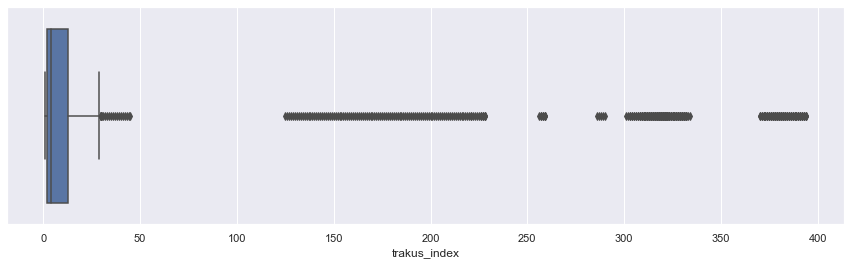

In [32]:
sns.set(rc={"figure.figsize":(15, 4)})
sns.boxplot(data=zero_dist, x="trakus_index");

<AxesSubplot:xlabel='trakus_index', ylabel='Count'>

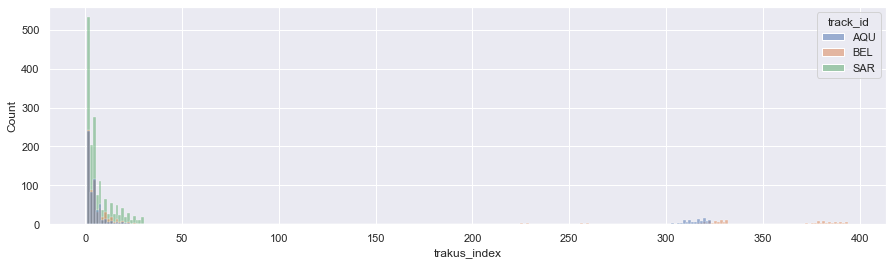

In [33]:
sns.histplot(data=zero_dist, x="trakus_index", hue="track_id")

#### Now looking at combination of high outliers calculated via IQR AND zero segment distance rows

In [35]:
high_zero_dist = (
    full
    .loc[(full['seg_dist_ft'] > (stats['seg_dist_ft'][6] + 1.5*seg_dist_IQR))
          | 
          (full['seg_dist_ft']==0)]
)

high_zero_dist_races = grouped_race_count(high_zero_dist)

sum_high_zero_dist_races = track_sums(high_zero_dist_races)

high_zero_dist_overall = combine_and_percent(sum_high_zero_dist_races, 'races_with_high_or_zero_distance_segments')
high_zero_dist_overall

,races_with_high_or_zero_distance_segments,total_races,percent_races_with_high_or_zero_distance_segments
track_id,,,
AQU,318,825,38.550000000
BEL,238,770,30.910000000
SAR,226,396,57.070000000


In [36]:
high_zero_dist['trakus_index'].value_counts().head(20)

1     574
2     517
3     447
4     354
5     285
6     204
7     161
8     136
9     114
10     81
11     73
12     64
13     63
14     52
15     49
58     45
16     43
17     43
52     42
57     42
Name: trakus_index, dtype: int64

In [37]:
#Number of readings for a given race with high oultier or 0 segment distance values
(
    high_zero_dist
    .groupby(['track_id', 'race_date', 'race_number'])
    ['horse_id']
    .count()
    .to_frame()
    .sort_values('horse_id', ascending=False)
    .head(20)
)

horse_id
track_id race_date  race_number          
SAR      2019-07-24 2                 300
                    5                 176
         2019-08-04 6                 147
AQU      2019-11-15 5                 127
         2019-11-17 6                 126
BEL      2019-06-01 3                 103
SAR      2019-07-17 8                  75
BEL      2019-09-18 2                  72
SAR      2019-08-03 3                  60
                    6                  60
         2019-09-02 3                  54
AQU      2019-11-03 9                  45
         2019-11-15 6                  43
SAR      2019-07-14 9                  39
BEL      2019-10-02 5                  38
SAR      2019-08-15 5                  38
         2019-08-17 2                  38
         2019-07-13 10                 37
         2019-07-28 2                  35
AQU      2019-03-15 9                  34

In [38]:
#stats for this group of readings
(
    high_zero_dist
    .groupby(['track_id', 'race_date', 'race_number'])
    ['horse_id']
    .count()
    .to_frame()
    .sort_values('horse_id', ascending=False)
    .describe()
)

,horse_id
count,782.000000000
mean,8.355498721
std,17.311826106
min,1.000000000
25%,1.000000000
50%,4.000000000
75%,9.000000000
max,300.000000000


In [39]:
#number of horses in a given race with high oultier or 0 segment distance readings
(
    high_zero_dist
    .groupby(['track_id', 'race_date', 'race_number'])
    ['horse_id']
    .nunique()
    .to_frame()
    .sort_values('horse_id', ascending=False)
    .head(20)
)

horse_id
track_id race_date  race_number          
AQU      2019-11-15 5                  11
         2019-11-01 2                  11
SAR      2019-08-03 3                  10
         2019-08-04 6                  10
AQU      2019-11-17 7                  10
SAR      2019-07-24 2                  10
         2019-08-07 10                  9
         2019-07-13 10                  9
         2019-07-26 7                   9
BEL      2019-10-02 2                   8
SAR      2019-07-24 5                   8
         2019-08-17 11                  8
AQU      2019-11-07 3                   8
         2019-11-15 6                   8
         2019-11-03 9                   8
SAR      2019-07-28 4                   7
         2019-08-15 5                   7
         2019-07-17 8                   7
AQU      2019-11-08 9                   7
         2019-12-01 4                   7

In [40]:
(
    high_zero_dist
    .groupby(['track_id', 'race_date', 'race_number'])
    ['horse_id']
    .nunique()
    .to_frame()
    .sort_values('horse_id', ascending=False)
    .describe()
)

,horse_id
count,782.000000000
mean,2.173913043
std,1.688383079
min,1.000000000
25%,1.000000000
50%,2.000000000
75%,3.000000000
max,11.000000000


In [ ]:
# Josh's angle formula
def get_angle_robust(point1, point2):
    try:
        vector_1 = np.array(point1)
        vector_2 = np.array(point2)
        unit_vector_1 = vector_1 / np.linalg.norm(vector_1)
        unit_vector_2 = vector_2 / np.linalg.norm(vector_2)
        dot_product = np.dot(unit_vector_1, unit_vector_2)
        angle = np.arccos(dot_product)
        return angle
    except:
        return np.nan

In [ ]:
with ThreadPoolExecutor(500) as executor:
    res = executor.map(vincenty_robust, complete['latlon'], complete['latlon_shift'])
complete['segment_distance'] = list(res)